In [12]:
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import plotly.express as px

import sklearn.model_selection
import numpy as np

from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.model_selection import KFold
import sklearn.metrics


RANDOM_STATE = 42
DATASET_YEAR = 2010

We want to predict house prices 

In [13]:
target_column = 'SalePrice'

### Training dataset 

In [14]:
df_train = pd.read_csv("datasets/train.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Test dataset 

In [15]:
df_test = pd.read_csv("datasets/test.csv")

### Numerical and categorical data

In [16]:
def convert_df(df):
    numerical_df = df.select_dtypes(include='number')
    categorical_df = df.select_dtypes(exclude='number')
    numerical_df = numerical_df.dropna(axis=1)
    onehot_df =  pd.get_dummies(categorical_df,dummy_na=False)
    all_df = pd.concat([numerical_df,onehot_df],axis=1)
    return all_df

In [38]:
train_with_categories = convert_df(df_train)
test_with_categories = convert_df(df_test)
columns_test_price[-1]

'Saleprice'

In [39]:
# columns that work for the training  
columns_test_price = test_with_categories.columns.values.tolist() + [target_column]
train_with_categories = train_with_categories[columns_test_price]
train_with_categories.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,8450,7,5,2003,2003,856,854,0,...,0,0,1,0,0,0,0,1,0,208500
1,2,20,9600,6,8,1976,1976,1262,0,0,...,0,0,1,0,0,0,0,1,0,181500
2,3,60,11250,7,5,2001,2002,920,866,0,...,0,0,1,0,0,0,0,1,0,223500
3,4,70,9550,7,5,1915,1970,961,756,0,...,0,0,1,1,0,0,0,0,0,140000
4,5,60,14260,8,5,2000,2000,1145,1053,0,...,0,0,1,0,0,0,0,1,0,250000


In [40]:
# remove ID 
train = train_with_categories.drop(columns=["Id"])

True

let's remove apply log when needed to normalise in the training dataset

In [48]:
print(train.columns.values)

['MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd'
 'Fireplaces' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch'
 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold' 'MSZoning_C (all)'
 'MSZoning_FV' 'MSZoning_RH' 'MSZoning_RL' 'MSZoning_RM' 'Street_Grvl'
 'Street_Pave' 'Alley_Grvl' 'Alley_Pave' 'LotShape_IR1' 'LotShape_IR2'
 'LotShape_IR3' 'LotShape_Reg' 'LandContour_Bnk' 'LandContour_HLS'
 'LandContour_Low' 'LandContour_Lvl' 'Utilities_AllPub' 'LotConfig_Corner'
 'LotConfig_CulDSac' 'LotConfig_FR2' 'LotConfig_FR3' 'LotConfig_Inside'
 'LandSlope_Gtl' 'LandSlope_Mod' 'LandSlope_Sev' 'Neighborhood_Blmngtn'
 'Neighborhood_Blueste' 'Neighborhood_BrDale' 'Neighborhood_BrkSide'
 'Neighborhood_ClearCr' 'Neighborhood_CollgCr' 'Neighborhood_Crawfor'
 'Neighborhood_Edwards' 'Neighborhood_Gilbert' 'Neighborhood_IDOTRR'
 'Neighborhood_MeadowV' '

<AxesSubplot: ylabel='Frequency'>

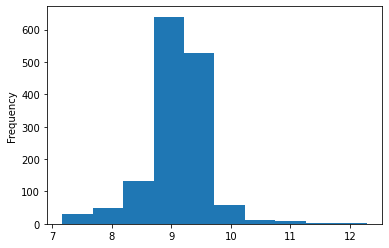

In [43]:
train.LotArea.map(lambda x : np.log(x)).plot.hist()

We need to apply log function to LotArea as to make it more of a normal distribution

<AxesSubplot: ylabel='Frequency'>

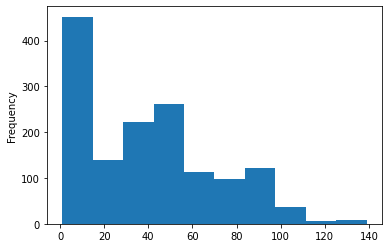

In [60]:
(2011 - train.YearBuilt).plot.hist()

In [ ]:
def transformations(df):
    df["LotArea"] = df.LotArea.map(lambda x : np.log(x))
    